In [5]:
#if youre running on colab, run this line first to properly load the h5 files
# !pip install tables --upgrade

In [1]:
# should be from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers.comet import CometLogger

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import glob
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#maybe downgrade?
np.__version__

'1.18.5'

In [4]:
#!pip install numpy --upgrade

# Homework 3
## Point Cloud MNIST with DeepSet


below you have a custom dataloader for the point-cloud MNIST dataset,

the training and validation datasets are linked from the course website

In [5]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        self.df = pd.read_hdf(path)
        
        self.label = torch.LongTensor(self.df.label)
        
        self.n_points = self.df.n_points
        
        
    def __len__(self):
       
        return len(self.label)


    def __getitem__(self, idx):
        
    #mod requires_grad=True
        return torch.FloatTensor(self.df.iloc[idx].xy), self.label[idx]
#         return torch.tensor(self.df.iloc[idx].xy,dtype=torch.float, requires_grad=True), self.label[idx]


In [6]:
path_to_training_data = './storage/data_for_pointcloud_MNIST/training_ds.h5'
path_to_validation_data = './storage/data_for_pointcloud_MNIST/valid_ds.h5'

In [7]:
ds = CustomDataset(path_to_training_data)

#### the data is exactly like the MNIST dataset, except that instead of a 28x28 image,
#### you get a (N x 2) array of points (different number of points for each item in the dataset) 

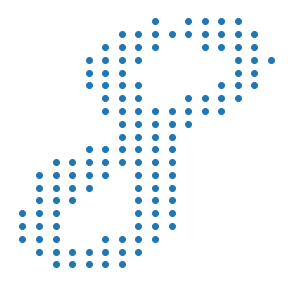

In [8]:
fig,ax = plt.subplots(figsize=(5,5))

xy = ds[445][0]

ax.scatter( xy[:,0],xy[:,1] )

ax.set_axis_off()

plt.show()

### the dataset object has a n_points variable that tells us how many points in each item

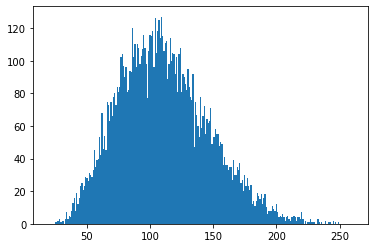

In [9]:
plt.hist(ds.n_points,np.linspace(19.5,260.5,242))
plt.show()

## One way to deal with this variable size is to use a custom Batch Sampler

https://pytorch.org/docs/stable/data.html

This object will tell our dataloader which item indices to request for the batches - 
and we can "rig" it to return batches where all the items have the same N, and therefore we can stack them without a custom colate function

In [10]:
class CustomBatchSampler(Sampler):
    def __init__(self, points_per_entry, batch_size):
        
        self.batch_size = batch_size
        self.N_per_entry = points_per_entry
        self.batches = {}
        # hacky
        self.n_batches = 246
        
    def generate_batches(self):
        
        self.entries_with_N = {}
        running_idx = -1

        for N in set(self.N_per_entry):
            
            self.entries_with_N[N] = np.where(self.N_per_entry == N)[0]

            how_many = len(self.entries_with_N[N])
            n_batches = np.amax([ how_many / self.batch_size, 1])

            self.entries_with_N[N] = np.array_split(np.random.permutation(self.entries_with_N[N]),
                                                           n_batches)
            for batch in self.entries_with_N[N]:
                running_idx += 1
                #MOD
#                 self.batches[running_idx] = batch
                self.batches[running_idx] = batch
                
        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        
        self.generate_batches()
        
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.batches[i]

In [11]:
batch_size = 50
batch_sampler = CustomBatchSampler(ds.n_points, batch_size)
data_loader = DataLoader(ds, batch_sampler=batch_sampler)

In [12]:
for sample in data_loader:
    x,y = sample
    break

## Building a DeepSet model

you only have three components - a fully connected network that creates the node embedding, a sum operation, and a classifier

## build the model, train, submit when you reach above 75% accuracy on the validation set:

In [13]:
import pytorch_lightning as pl

In [14]:
import torch.nn.functional as F

In [15]:
NUM_CLASSES = 10

In [16]:
LOSS_FUNC = F.cross_entropy

In [17]:
# class ImageClassifier(nn.Module):
class DeepSet(pl.LightningModule):
    
    def __init__(self):        
        super().__init__()
        
        self.counter = 0
        
        self.hidsize = 32*32
        
        
        #MOD
        self.embedding = nn.Linear(2,self.hidsize)
        
        #LeNet
#         self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
#         self.conv2 = nn.Conv2d(6, 16, (5,5))
#         self.fc1   = nn.Linear(16*5*5, 120)
        self.fc1  = nn.Linear(self.hidsize,120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
        self.classifier = nn.Sequential(
            
            
        
            # mod by feat
            nn.Linear(self.hidsize,4096),
            
            nn.ReLU(True),
#             nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            # MOD
#             nn.Dropout(),
            #num_classes = 10
            nn.Linear(4096, NUM_CLASSES),
        )
        
    def forward(self, batch):
        
#         print('in',batch.shape)
        # not helping
        batch.requires_grad_(True)
#         print(batch)
        
#         self.hidsize = 2048
        
        out = self.embedding(batch)
        
        out = F.relu(out)
        
        out = torch.mean(out,dim=1)
        
        #LeNet
#         x = F.max_pool2d(F.relu(self.conv1(out)), (2,2))
#         x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
#         x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(out))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)

#         out = self.classifier(out)
        
#         print('out',out)
        
#         print ('out',out.shape)
#         print('out.grad_fn',out.grad_fn)
        return out
    
    
    def train_dataloader(self):
        dataset_train = CustomDataset(path_to_training_data)
        batch_sampler = CustomBatchSampler(dataset_train.n_points, batch_size=50)
#         self.Ns = batch_sampler.entries
#         return DataLoader(dataset_train,batch_sampler=batch_sampler,num_workers=4)
        return DataLoader(dataset_train,batch_sampler=batch_sampler, num_workers=4)

    def val_dataloader(self):
        dataset_val = CustomDataset(path_to_validation_data)
        batch_sampler_val = CustomBatchSampler(dataset_val.n_points,batch_size=50)
        # MOD num_workers on local
        return DataLoader(dataset_val,batch_sampler=batch_sampler_val,num_workers=4)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    
    def training_step(self,batch,batch_idx):
#         print('batch_ix',batch_idx)
#         print('batch',batch)
        minib,target = batch
        yhat = self(minib)
#         print('yhat',yhat)
#         print('target',target)
#         out = self.forward(minib)
        loss = LOSS_FUNC(yhat,target)
#         loss.requires_grad_(True)
#         print('loss.requires_grad',loss.requires_grad)
#         print('loss',loss)
        
    
        # try this
#         pred = yhat.argmax(dim=1, keepdim=True) #get ix of max log-proba
#         correct = pred.eq(target.view_as(pred)).sum().item()
#         accuracy = correct/len(minib)
        
#         # add logging
#         logs = {'train_loss': loss,'train_accuracy':accuracy}
        logs = {'train_loss':loss}
#         print('logs',logs)
        return {'loss': loss, 'log': logs}
#         return loss
    
    def validation_step(self,batch,batch_idx):
        minib, target = batch
#         out = self.forward(minib)
        yhat = self(minib)
#         print('valid y_hat',yhat.shape)
        # mod to torch.tensor
        loss = LOSS_FUNC(yhat,target)
        
        pred = yhat.argmax(dim=1, keepdim=True) #get ix of max log-proba
#         print('valid pred',pred.shape)
        correct = pred.eq(target.view_as(pred)).sum().item()
        #mod to torch.tensor forr avg_acc
        accuracy = torch.tensor(correct/len(minib))
        
#         logs = {'train_loss': loss,'val_accuracy':accuracy}
#         return {'val_loss': loss, 'log': logs}
        step_dict = {'val_step_loss':loss, 'val_step_acc':accuracy}
        return step_dict
        
    
    def validation_epoch_end(self, outputs):
        #TODO imbalanced given each batch is of a different size...
        avg_loss = torch.stack([x['val_step_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_step_acc'] for x in outputs]).mean()
        
        #MOD rm .item()
#         tqdm_dict = {'val_acc': avg_acc}

        # show val_acc in progress bar but only log val_loss
        # MOD rm .item() from avg_acc and avg_loss
        results = {
#             'progress_bar': tqdm_dict,
            'log': {'val_acc': avg_acc,
                    'val_loss': avg_loss
                   }
        }
        print ('epoch',self.counter,':',results) 
        self.counter +=1
        return results
#         logs = {'val_loss':avg_loss}
#         return {'avg_val_loss':avg_loss, 'log':tensorboard_logs}

In [88]:
torch.randn(10).view(-1)

tensor([ 1.2076, -0.6898,  0.1618, -0.4709, -0.3754,  1.4918, -0.3368, -1.8876,
        -0.5340,  0.3247])

In [32]:
# from pytorch_lightning.callbacks import Callback

# class MyPrintingCallback(Callback):

#     def on_init_start(self, trainer):
#         print('Starting to init trainer!')

#     def on_init_end(self, trainer):
#         print('Trainer is init now')

#     def on_train_end(self, trainer, pl_module):
#         print('do something when training ends')

In [19]:
experiment = 'deepsettest_lenetlte'

In [20]:
comet_logger = CometLogger(
    api_key='n0QCcEJ7YYeDUkff49kqLEdeJ',
    workspace="ren-e1011",
    project_name="dl1010-a3", 
    experiment_name=experiment  
)

CometLogger will be initialized in online mode
COMET INFO: old comet version (3.1.9) detected. current: 3.1.12 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ren-e1011/dl1010-a3/3969f975d9274b87bae192074bdcf5e2



In [24]:
trainer = pl.Trainer(max_epochs=45, logger=comet_logger,gpus=1)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [25]:
trainer.fit(net)

COMET INFO: old comet version (3.1.9) detected. current: 3.1.12 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ren-e1011/dl1010-a3/3969f975d9274b87bae192074bdcf5e2


  | Name         | Type       | Params
----------------------------------------
0 | embedding    | Linear     | 3 K   
1 | fc1          | Linear     | 123 K 
2 | fc2          | Linear     | 10 K  
3 | fc3          | Linear     | 850   
4 | classifier   | Sequential | 21 M  
5 | classifier.0 | Linear     | 4 M   
6 | classifier.1 | ReLU       | 0     
7 | classifier.2 | Linear     | 16 M  
8 | classifier.3 | ReLU       | 0     
9 | classifier.4 | Linear     | 40 K  
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /notebooks/dl1010-a3/3969f975d9274b87bae192074bdcf5e2/checkpoints exists and is not empty with save_top_k != 0.All files in this directo

epoch 51 : {'log': {'val_acc': tensor(1.), 'val_loss': tensor(0.0313, device='cuda:0')}}


epoch 52 : {'log': {'val_acc': tensor(0.8244), 'val_loss': tensor(0.5387, device='cuda:0')}}


epoch 53 : {'log': {'val_acc': tensor(0.7784), 'val_loss': tensor(0.6748, device='cuda:0')}}


epoch 54 : {'log': {'val_acc': tensor(0.8422), 'val_loss': tensor(0.5096, device='cuda:0')}}


epoch 55 : {'log': {'val_acc': tensor(0.7985), 'val_loss': tensor(0.6000, device='cuda:0')}}


epoch 56 : {'log': {'val_acc': tensor(0.8449), 'val_loss': tensor(0.4898, device='cuda:0')}}


epoch 57 : {'log': {'val_acc': tensor(0.8370), 'val_loss': tensor(0.5001, device='cuda:0')}}


epoch 58 : {'log': {'val_acc': tensor(0.8454), 'val_loss': tensor(0.4909, device='cuda:0')}}


epoch 59 : {'log': {'val_acc': tensor(0.7561), 'val_loss': tensor(0.7578, device='cuda:0')}}


epoch 60 : {'log': {'val_acc': tensor(0.8296), 'val_loss': tensor(0.5404, device='cuda:0')}}


epoch 61 : {'log': {'val_acc': tensor(0.8326), 'val_loss': tensor(0.5120, device='cuda:0')}}


epoch 62 : {'log': {'val_acc': tensor(0.8467), 'val_loss': tensor(0.4857, device='cuda:0')}}


epoch 63 : {'log': {'val_acc': tensor(0.8429), 'val_loss': tensor(0.4908, device='cuda:0')}}


epoch 64 : {'log': {'val_acc': tensor(0.8269), 'val_loss': tensor(0.5277, device='cuda:0')}}


epoch 65 : {'log': {'val_acc': tensor(0.8024), 'val_loss': tensor(0.6301, device='cuda:0')}}


epoch 66 : {'log': {'val_acc': tensor(0.8199), 'val_loss': tensor(0.5671, device='cuda:0')}}


epoch 67 : {'log': {'val_acc': tensor(0.8395), 'val_loss': tensor(0.4828, device='cuda:0')}}


epoch 68 : {'log': {'val_acc': tensor(0.8421), 'val_loss': tensor(0.5091, device='cuda:0')}}


epoch 69 : {'log': {'val_acc': tensor(0.8389), 'val_loss': tensor(0.4988, device='cuda:0')}}


epoch 70 : {'log': {'val_acc': tensor(0.8582), 'val_loss': tensor(0.4433, device='cuda:0')}}


epoch 71 : {'log': {'val_acc': tensor(0.8316), 'val_loss': tensor(0.5223, device='cuda:0')}}


epoch 72 : {'log': {'val_acc': tensor(0.7900), 'val_loss': tensor(0.6432, device='cuda:0')}}


epoch 73 : {'log': {'val_acc': tensor(0.8538), 'val_loss': tensor(0.4579, device='cuda:0')}}


epoch 74 : {'log': {'val_acc': tensor(0.8312), 'val_loss': tensor(0.5154, device='cuda:0')}}


epoch 75 : {'log': {'val_acc': tensor(0.8534), 'val_loss': tensor(0.4650, device='cuda:0')}}


epoch 76 : {'log': {'val_acc': tensor(0.8579), 'val_loss': tensor(0.4549, device='cuda:0')}}


epoch 77 : {'log': {'val_acc': tensor(0.8258), 'val_loss': tensor(0.5459, device='cuda:0')}}


epoch 78 : {'log': {'val_acc': tensor(0.8527), 'val_loss': tensor(0.4691, device='cuda:0')}}


epoch 79 : {'log': {'val_acc': tensor(0.7895), 'val_loss': tensor(0.6319, device='cuda:0')}}


epoch 80 : {'log': {'val_acc': tensor(0.8475), 'val_loss': tensor(0.4797, device='cuda:0')}}


epoch 81 : {'log': {'val_acc': tensor(0.8489), 'val_loss': tensor(0.4749, device='cuda:0')}}


epoch 82 : {'log': {'val_acc': tensor(0.8447), 'val_loss': tensor(0.4808, device='cuda:0')}}


epoch 83 : {'log': {'val_acc': tensor(0.8373), 'val_loss': tensor(0.5281, device='cuda:0')}}


epoch 84 : {'log': {'val_acc': tensor(0.8685), 'val_loss': tensor(0.4311, device='cuda:0')}}


epoch 85 : {'log': {'val_acc': tensor(0.8365), 'val_loss': tensor(0.5276, device='cuda:0')}}


epoch 86 : {'log': {'val_acc': tensor(0.8745), 'val_loss': tensor(0.4181, device='cuda:0')}}


epoch 87 : {'log': {'val_acc': tensor(0.8664), 'val_loss': tensor(0.4300, device='cuda:0')}}


epoch 88 : {'log': {'val_acc': tensor(0.8560), 'val_loss': tensor(0.4775, device='cuda:0')}}


epoch 89 : {'log': {'val_acc': tensor(0.8608), 'val_loss': tensor(0.4279, device='cuda:0')}}


epoch 90 : {'log': {'val_acc': tensor(0.8667), 'val_loss': tensor(0.4147, device='cuda:0')}}


epoch 91 : {'log': {'val_acc': tensor(0.8419), 'val_loss': tensor(0.4758, device='cuda:0')}}


epoch 92 : {'log': {'val_acc': tensor(0.8618), 'val_loss': tensor(0.4442, device='cuda:0')}}


epoch 93 : {'log': {'val_acc': tensor(0.8597), 'val_loss': tensor(0.4327, device='cuda:0')}}


epoch 94 : {'log': {'val_acc': tensor(0.8621), 'val_loss': tensor(0.4416, device='cuda:0')}}


epoch 95 : {'log': {'val_acc': tensor(0.8644), 'val_loss': tensor(0.4178, device='cuda:0')}}


COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/ren-e1011/dl1010-a3/3969f975d9274b87bae192074bdcf5e2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [1170]      : (0, 44)
COMET INFO:     train_loss [1125] : (0.0003941059112548828, 3.044437885284424)
COMET INFO:     val_acc [45]      : (0.7561344504356384, 0.8745254278182983)
COMET INFO:     val_loss [45]     : (0.4077610373497009, 0.7578346729278564)
COMET INFO: -----------------------------------
COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


epoch 96 : {'log': {'val_acc': tensor(0.8718), 'val_loss': tensor(0.4078, device='cuda:0')}}



1

In [27]:
torch.save(net.state_dict(),experiment+'_95epch.pt')

In [39]:
def compute_accuracy(data_loader,net):
    
    net.eval()
    
    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:
        
#         prediction = net(x).data.numpy()
        prediction = net(x)
        
        prediction = np.argmax(prediction,axis=1)
        
        correct = len( np.where(prediction==y.data.numpy())[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
        
    return total_correct/float(total_number)

In [ ]:
test_ds = CustomDataset(path_to_validation_data)
batch_size = 50
batch_sampler_test_ds = CustomBatchSampler(test_ds.n_points, batch_size)
data_loader_test = DataLoader(test_ds, batch_sampler=batch_sampler_test_ds)

compute_accuracy(data_loader_test,net)